<a href="https://colab.research.google.com/github/MehrdadDastouri/cartpole_dqn/blob/main/cartpole_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10/500, Average Reward (last 10): 23.30, Epsilon: 0.95
Episode 20/500, Average Reward (last 10): 20.90, Epsilon: 0.90
Episode 30/500, Average Reward (last 10): 34.20, Epsilon: 0.86
Episode 40/500, Average Reward (last 10): 31.10, Epsilon: 0.82
Episode 50/500, Average Reward (last 10): 47.60, Epsilon: 0.78
Episode 60/500, Average Reward (last 10): 45.70, Epsilon: 0.74
Episode 70/500, Average Reward (last 10): 31.80, Epsilon: 0.70
Episode 80/500, Average Reward (last 10): 58.20, Epsilon: 0.67
Episode 90/500, Average Reward (last 10): 54.00, Epsilon: 0.64
Episode 100/500, Average Reward (last 10): 50.60, Epsilon: 0.61
Episode 110/500, Average Reward (last 10): 72.60, Epsilon: 0.58
Episode 120/500, Average Reward (last 10): 59.20, Epsilon: 0.55
Episode 130/500, Average Reward (last 10): 78.10, Epsilon: 0.52
Episode 140/500, Average Reward (last 10): 77.20, Epsilon: 0.50
Episode 150/500, Average Reward (last 10): 116.50, Epsilon: 0.47
Episode 160/500, Average Reward (last 10): 114.8

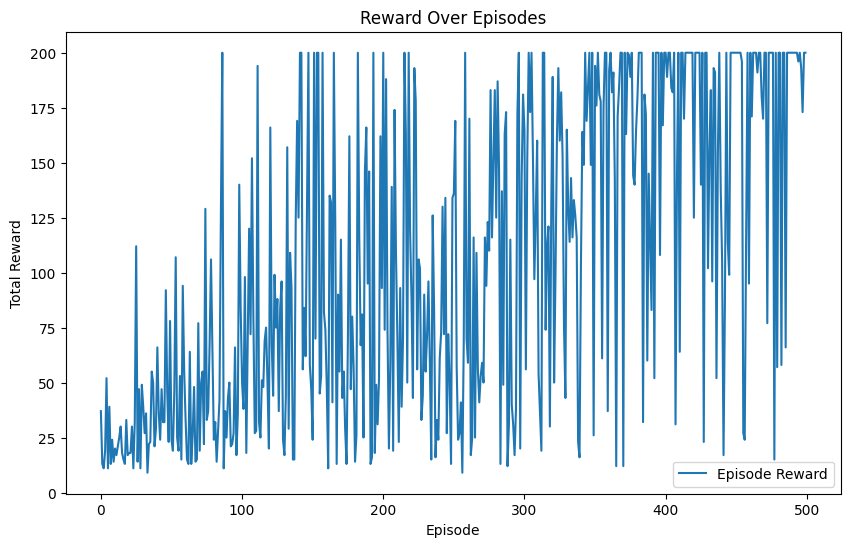

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_reso

Test Episode Reward: 155.0


In [2]:
# Importing necessary libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate
learning_rate = 0.001
batch_size = 64
target_update_freq = 10  # Frequency of target network update
episodes = 500  # Number of episodes
memory_size = 10000  # Replay memory size

# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Replay memory
memory = deque(maxlen=memory_size)

# Neural network for Q-function approximation
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-network and target network
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()

# Optimizer
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

# Function to select an action using epsilon-greedy strategy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)  # Random action (exploration)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_network(state)
        return torch.argmax(q_values).item()  # Greedy action (exploitation)

# Function to train the Q-network
def train_q_network():
    if len(memory) < batch_size:
        return

    # Sample a batch from the replay memory
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    # Compute Q-values for current states
    q_values = q_network(states).gather(1, actions)

    # Compute target Q-values
    with torch.no_grad():
        max_next_q_values = target_network(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

    # Compute loss
    loss = nn.MSELoss()(q_values, target_q_values)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
rewards_per_episode = []
for episode in range(1, episodes + 1):
    state = env.reset()
    total_reward = 0

    for t in range(200):  # Limit the number of steps per episode
        # Select an action
        action = select_action(state, epsilon)

        # Perform the action
        next_state, reward, done, _ = env.step(action)

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))

        # Update the state
        state = next_state
        total_reward += reward

        # Train the Q-network
        train_q_network()

        if done:
            break

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Update target network
    if episode % target_update_freq == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Store the total reward for this episode
    rewards_per_episode.append(total_reward)

    # Print progress
    if episode % 10 == 0:
        avg_reward = np.mean(rewards_per_episode[-10:])
        print(f"Episode {episode}/{episodes}, Average Reward (last 10): {avg_reward:.2f}, Epsilon: {epsilon:.2f}")

# Plot rewards over episodes
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Over Episodes")
plt.legend()
plt.show()

# Test the trained agent
state = env.reset()
total_reward = 0
for t in range(200):
    env.render()
    action = select_action(state, epsilon=0.0)  # Use greedy policy for testing
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break
print(f"Test Episode Reward: {total_reward}")
env.close()